
# OpenCV + Multitask learning

### Что модель должна уметь? 
 - По фотографии определить пол, возраст и рассу человека или людей на ней находящихся. 

Перед началом, важно сказать, что во время работы я опирался на одно из домашних заданий онлайн курса, который я проходил во время своего обучения. 

[Датасет](https://susanqq.github.io/UTKFace/), который будет использовать состоит из 20000 фотографий лиц людей в возрасте от 0 до 116 лет! В качестве разметки имеется пол (male/female), раса (white/black/asian/indian/other) и возраст. Классификация с настолько сильной внутриклассовой изменьчивостью (от младенцев до пожилых людей!) -- очень сложная задача. 
![alt text](https://susanqq.github.io/UTKFace/icon/samples.png)


Как решать такую задачу? Я воспользуюсь **transfer learning и finetuning**. Т.е. возьму за основу сеть, обученную на большом количестве данных для другой задачи и дообучить ее для нашей задачи.


Датасетом, с которого чаще всего "переносят" знания, является известный ImageNet. В этой работе за основу я взял сеть, которая была обучена на датасете [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/) для классификации лиц. Он содержит 3.3 миллиона изображений с 9000 разными персоналиями. **Почему выбор пал в пользу VGGFace2?**

Датасет VGGFace2 гораздо ближе к моей задаче. Значит, признаки которые он научился извлекать из изображений будут гораздо полезнее и помогут обучить модель лучше и быстрее.




## Загрузка обученной модели

Сеть, которую буду обучать взяза из открытого источника: https://github.com/rcmalli/keras-vggface .

In [1]:
! pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-d0vuf59z
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-d0vuf59z
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8310 sha256=e2475a2d7ac6f9e8bef2cf6a0c3db4309b1d6328f6bc3b3376a97f8c4a395b90
  Stored in directory: /tmp/pip-ephem-wheel-cache-k5y_tjij/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import tensorflow as tf
tf.__version__

'1.15.2'

In [4]:
import tensorflow as tf
# tf.enable_eager_execution()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

Т.к. я решили воспользоваться чужой моделью, нам нужно сначала понять как с ней взаимодействовать. Для этого авторы часто прикладывают пример использования своих моделей. Его можно найти в README у автора репозитория.

Пример из репозитория не использует режим eager_execution, поэтому я воспользовался сохранённой моделью, переписанной без него и доступной по ссылке  https://drive.google.com/open?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO . 

Загрузим модель:



In [6]:
! pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO'
output = 'resnet50face.h5'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO
To: /content/resnet50face.h5
166MB [00:01, 133MB/s] 


'resnet50face.h5'

In [7]:
from tensorflow.keras.models import load_model
vggface_model = load_model("resnet50face.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Модель загружена, посмотрим, что она из себя представляет. Это архитектура -- ResNet. На самом деле внутренности модели не очень важны для нас -- в дальнейшем я заморожу бОльшую часть этой сети и буду рабоать только с последними слоями. Нам важно, что она обучена и мы имеем доступ к ее архитектуре и весам.

In [8]:
len(vggface_model.layers)

176

In [9]:
vggface_model.summary() # последний слой классифицирует на 8631 классов

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

После загрузки запустим полный пример из репозитория:

In [10]:
! wget https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg -O brad_pitt.jpg

--2021-01-13 11:40:16--  https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.ua (img.joinfo.ua)... 104.26.15.191, 104.26.14.191, 172.67.69.123, ...
Connecting to img.joinfo.ua (img.joinfo.ua)|104.26.15.191|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43154 (42K) [image/jpeg]
Saving to: ‘brad_pitt.jpg’

brad_pitt.jpg       100%[===================>]  42.14K  --.-KB/s    in 0.02s   

2021-01-13 11:40:17 (2.46 MB/s) - ‘brad_pitt.jpg’ saved [43154/43154]



Using TensorFlow backend.


1351680/1346516 [==============================] - 0s 0us/step


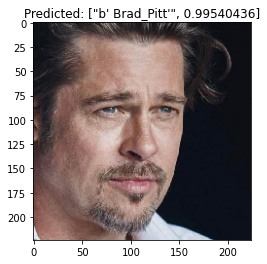

In [11]:
from keras_vggface import utils
from tensorflow.keras.preprocessing import image

img = image.load_img("brad_pitt.jpg", target_size=(224, 224)) # модель работает с картинками размера 224 на 224
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) # мы используем resnet50 -- поэтому version2. Эта функция нам еще пригодится!

preds = vggface_model.predict(x) # модель -- известная нам keras model, вызываем predict
plt.title(f"Predicted: {utils.decode_predictions(preds)[0][0]}") # используем  decode_predictions из keras_vggface
plt.imshow(img);

## Загрузка данных
Убедились, что модель загружена правильно, узнали какой препроцессинг ей необходим (utils.preprocess_input(x, version=2)) и теперь можно перейти к загрузке наших данных.

In [12]:
from pathlib import Path
from collections import Counter

In [13]:
url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/
url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
107MB [00:00, 133MB/s]  
Downloading...
From: https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2
To: /content/train_val_split_utk.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 136MB/s]


'train_val_split_utk.csv'

In [14]:
data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print(len(filenames))
print(filenames[:3]) # имя файла содержит возраст, индекс пола и расы, перечисленные через нижнее подчеркивание

23708
['17_0_1_20170117103419741.jpg.chip.jpg', '12_0_0_20170110225330874.jpg.chip.jpg', '27_1_3_20170117175958932.jpg.chip.jpg']


In [15]:
# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 39_1_20170116174525125.jpg.chip.jpg
Bad filename 61_1_20170109142408075.jpg.chip.jpg
Bad filename 61_1_20170109150557335.jpg.chip.jpg


,img_name,age,race,gender
0,65_0_0_20170111204905982.jpg.chip.jpg,0.560345,0,0
1,66_1_0_20170110160643985.jpg.chip.jpg,0.568965,0,1
2,1_1_0_20170109194452834.jpg.chip.jpg,0.008621,0,1
3,3_1_2_20161219162325990.jpg.chip.jpg,0.025862,2,1
4,45_0_3_20170117183557423.jpg.chip.jpg,0.387931,3,0


In [16]:
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()

,is_train
img_name,
29_0_0_20170117180855986.jpg.chip.jpg,1
29_0_4_20170117202712541.jpg.chip.jpg,1
35_0_1_20170117104607288.jpg.chip.jpg,1
17_0_0_20170110231830374.jpg.chip.jpg,1
23_0_0_20170117194023317.jpg.chip.jpg,1


In [17]:
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

4759 18946


In [18]:
race_mapping

{0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

In [19]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
    
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

Убедимся, что метки классов корректны:

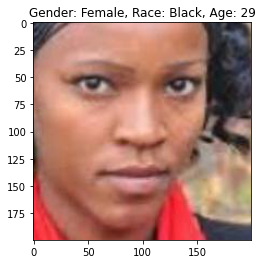

In [20]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

Посмотрим на их распределение:

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


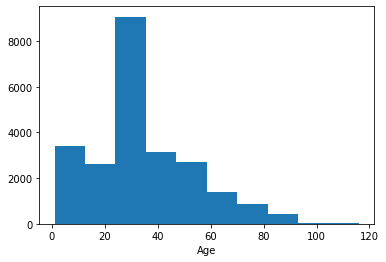

In [21]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]
from collections import Counter
print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_vggface import utils

def preprocess_input_facenet(image):
    """
    image -- тензор размера (1, H, W, 3)
    
    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface (см пример с Бредом Питом)
    """
    x = np.expand_dims(image, axis=0)
    preprocessed = utils.preprocess_input(x, version=2)
    assert preprocessed.shape == (1, 224, 224, 3), 'Wrong preprocessed image shape!'
    return preprocessed

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

Резилуем функцию `deprocess_image`, которая преобразует картинку исользуемую keras_vggface обратно к изображению, которое можно визуализировать с помощью `matplotlib`.

In [23]:
from keras import backend as K
print(K.image_data_format())
def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) картинка после препросессинга. 
    содержит отрицательные значения и некорректно отображается matplotlib

    return: корректно отображаеая картинка типа np.uint8(!!). 

    ! работайте с копией картинки (image = np.copy(vggface_image)) !
    """
    image = np.copy(vggface_image)
    image[..., 0] += 91.4953
    image[..., 1] += 103.8827
    image[..., 2] += 131.0912
    image = image[..., ::-1]
    image = image.astype(np.uint8)
    return np.uint8(image)

channels_last


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
from pathlib import Path

In [26]:
#@title (вспомогательный код, выполните клетку) { display-mode: "form" }
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')
        

## Multitask learning

Если на каждый атрибут (возраст, раса, пол) создавать одну модель, то таких моделей получится 3. Очевидно, что для предсказания на новой картике необходимо будет произвести инференс трех сетей. Это может быть ресурсо-затратно и сложнее в поддержке. 

Какой же есть еще подход? Он называется Multitask learning. Его идея в том, чтобы обучать одну модель для решения сразу нескольких задач! Гибкость нейронных сетей позволяет это сделать достаточно логичными образом. Необходимо вместо одной "головы" для предсказания сделать несколько. Таким образом одна будет отвечать за классификацию пола (1 выход, вероятность), вторая -- за классификацию расы (5 выходов, вероятности) и третья -- за предсказания возраста (1 выход, число).

In [27]:
BATCH_SIZE = 128 
IMAGE_SIZE = 224

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 2048)         23561152    input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           131136      model[1][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           2080        dense[0][0]                      
____________________________________________________________________________________________

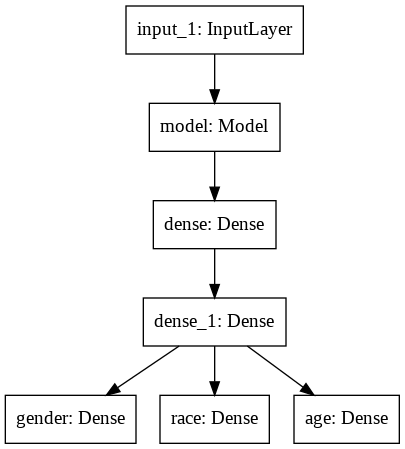

In [28]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)

base_model.trainable = True
fine_tune_at = 170
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

base_layes = base_model(input_layer)
dense1 = tf.keras.layers.Dense(64, activation = 'relu')(base_layes)
dense2 = tf.keras.layers.Dense(32, activation = 'relu')(dense1)
gender_output = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'gender')(dense2)
race_output = tf.keras.layers.Dense(5, activation = 'softmax', name = 'race')(dense2)
age_output = tf.keras.layers.Dense(1, name  = 'age')(dense2)
model = tf.keras.Model(inputs = input_layer, outputs = [gender_output, race_output, age_output])

model.summary()
plot_model(model)

In [29]:
prediction = model(np.zeros((6, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32))
assert len(prediction) == 3, "Модель должна возвращать три тензора"
assert prediction[0].shape == (6, 1), f"Неправильный размер выхода gender: {prediction[0].shape}"
assert prediction[1].shape == (6, 5), f"Неправильный размер выхода race: {prediction[1].shape}"
assert prediction[2].shape == (6, 1), f"Неправильный размер выхода age: {prediction[2].shape}"
print("Shape tests passed")

Shape tests passed


Для генерации картинок был выбрал `image_gen.flow_from_dataframe`, который позволяет генерировать данные с нужными классами используя датафрейм.


In [30]:
train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode="other", # В документации нет такой опции как 'other'
        x_col="img_name", y_col=["gender", "race",
                                 "age"
                                 ], # нас интересуют все три столбца
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)

val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="other",
        x_col="img_name", y_col=["gender", "race", 
                                 "age"
                                 ],
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)

def split_outputs(generator):
    """
    Вспомогательная функция, которая модернизирует генераторы картинок, чтобы их
    можно было использовать для Мultitask
    image_gen.flow_from_dataframe возвращает на каждой итерации батч:
    ((N, H, W, 3), (N, 3)) -- N картинок и N троек меток (для трех "задач")
    model.fit(..) ожидает генератор в формате:
    ((N, H, W, 3), [(N, 1), (N, 1), (N, 1)])

    Для такого превращения и нужна эта функция.

    """
    while True:
        data = next(generator)
        image = data[0]
        # labels = np.array(data[1])
        # labels = np.split(data[1], 3, axis=1)
        # lable_data = np.vstack([data[1][0], data[1][1], data[1][2]]).T
        labels = np.split(data[1], 3, axis=1)
        yield image, labels

Found 18946 validated image filenames.
Found 4759 validated image filenames.


С подбором парметров для модели, я сильно не замарачивался

In [31]:
validation_steps = len(df_val) // BATCH_SIZE

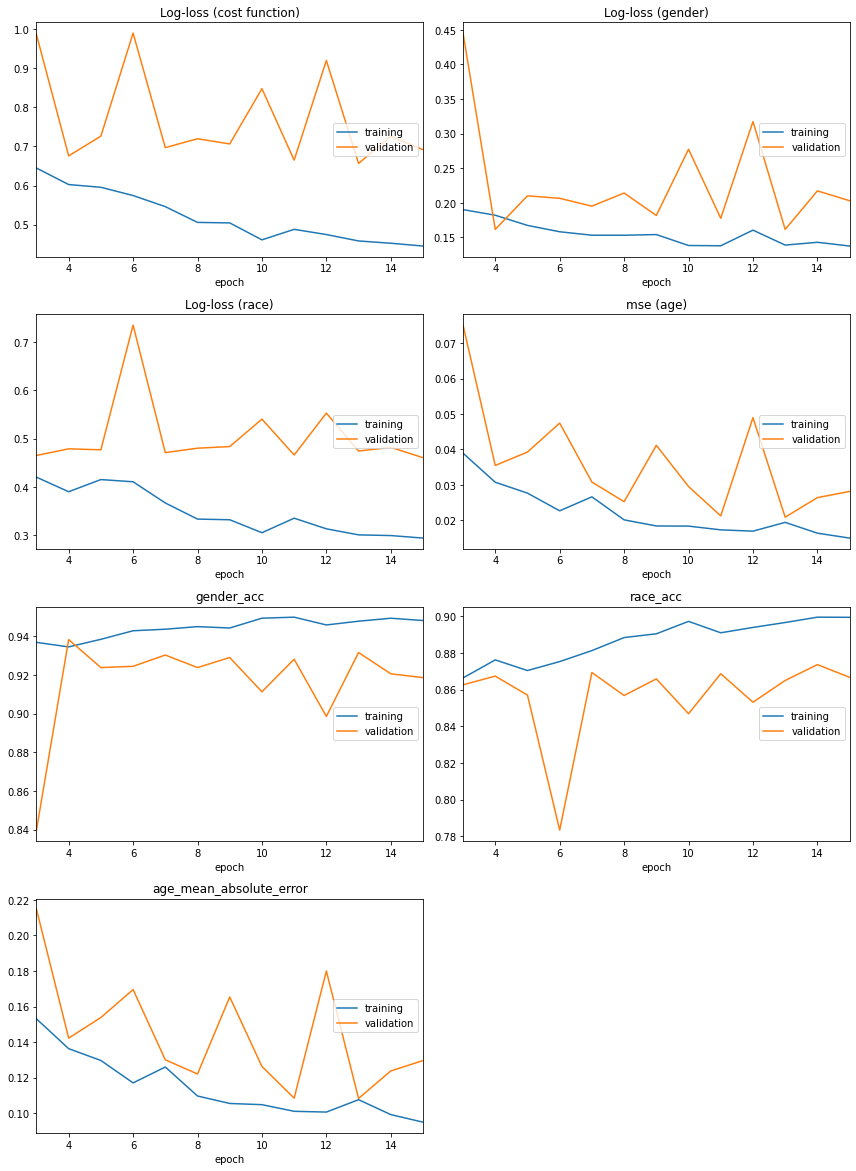

Log-loss (cost function):
training   (min:    0.446, max:    1.972, cur:    0.446)
validation (min:    0.657, max:    0.989, cur:    0.692)

Log-loss (gender):
training   (min:    0.138, max:    0.482, cur:    0.138)
validation (min:    0.162, max:    0.445, cur:    0.203)

Log-loss (race):
training   (min:    0.294, max:    1.021, cur:    0.294)
validation (min:    0.460, max:    0.735, cur:    0.460)

mse (age):
training   (min:    0.015, max:    0.469, cur:    0.015)
validation (min:    0.021, max:    0.144, cur:    0.028)

gender_acc:
training   (min:    0.781, max:    0.950, cur:    0.948)
validation (min:    0.840, max:    0.938, cur:    0.919)

race_acc:
training   (min:    0.657, max:    0.900, cur:    0.899)
validation (min:    0.783, max:    0.874, cur:    0.867)

age_mean_absolute_error:
training   (min:    0.095, max:    0.396, cur:    0.095)
validation (min:    0.108, max:    0.299, cur:    0.130)

Epoch 00015: val_age_mean_absolute_error did not improve from 0.10826
100/1

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) 

model.compile(optimizer=optimizer, 
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': 'accuracy', 'age': 'mae'})

path = Path("model_multitask")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_age_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

model.fit_generator(split_outputs(train_generator), epochs=15, validation_data=split_outputs(val_generator),
                    callbacks=[PlotLossesCallback(), checkpoint], steps_per_epoch=100, 
                    validation_steps = validation_steps)

In [34]:
model_multitask = load_model("model_multitask/checkpoint_best.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [35]:
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="other",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        
        shuffle=True)

results = model_multitask.evaluate(split_outputs(val_generator), steps=len(df_val)//BATCH_SIZE)

Found 4759 validated image filenames.
37/37 [==============================] - 9s 233ms/step - loss: 0.6622 - gender_loss: 0.1687 - race_loss: 0.4722 - age_loss: 0.0213 - gender_acc: 0.9299 - race_acc: 0.8659 - age_mean_absolute_error: 0.1090


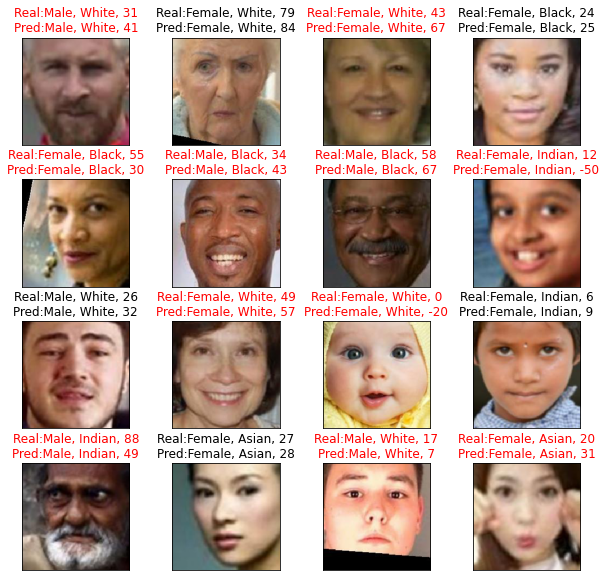

In [37]:
sample_validation_images, sample_validation_labels = next(split_outputs(val_generator))
predicted = model_multitask.predict(sample_validation_images)
show_faces(sample_validation_images, 
           real_gender=sample_validation_labels[0], predicted_gender=predicted[0],
           real_race=sample_validation_labels[1], predicted_race=predicted[1],
           real_age=sample_validation_labels[2].flatten(), predicted_age=predicted[2].flatten(),
           )

In [ ]:
Возраст определяет плохо, поэтому архитектуру и гиперпараметры можно ещё подкрутить